In [248]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import SVG,display, HTML

import requests
import pickle

from sklearn.neighbors import KDTree

In [569]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow"]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working", "liter", "plenty"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))


tank_keywords = ["tank", "cache"]
def isTank(description):
    return any([kw in description for kw in tank_keywords])
assert(isTank("tank empty"))

In [570]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [482]:
# functions for finding the last positive result and last negative result
def last_pos(mile, date):
    last_pos_date = data[(data.mile == mile) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 2000
    return (date - last_pos_date).days
    
def last_neg(mile, date):
    last_neg_date = data[(data.mile == mile) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 2000
    return (date - last_neg_date).days

In [483]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}

In [549]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","name", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","name", "description", "date", "user"]
        yield data

In [550]:
# import and combine tip line data
data_tip = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [551]:
data_gh=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [552]:
# clean up the guthook dates
data_gh.date = pd.to_datetime(data_gh.date)

In [553]:
# clean up the lod_ids in the tip line data
data_tip.loc_id = data_tip.loc_id.apply(clean_loc_id)

In [554]:
# create lat and lon columns
data_tip["lat"] = data_tip["loc_id"].map(lat)
data_tip["lon"] = data_tip["loc_id"].map(lon)

In [555]:
# merge the two mile fields in the tip lin data
data_tip.mile = data_tip.mile.fillna(data_tip.mile_2)

In [556]:
# drop data with missing coordinates
data_tip = data_tip.dropna(subset=["lat", "mile"])

In [557]:
data = pd.concat([data_tip, data_gh])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [558]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [559]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [571]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["tank"] = data["description"].map(isTank, na_action="ignore")
data["decision"] = (data.flowing^data.not_flowing)&(~data.tank.astype(bool)) # logical xor
data["status"] = data.flowing.astype(float)

In [572]:
print(f"only one {(data.flowing^data.not_flowing).sum()}")
print(f"at least one {(data.flowing|data.not_flowing).sum()}")
print(f"both {(data.flowing&data.not_flowing).sum()}")
print(f"tank {data.tank.sum()}")


only one 43781
at least one 44859
both 1078
tank 1694


In [573]:
# remove all data with no decision
data = data[data.decision]

In [574]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","mile"])

In [622]:
data['month'] = data.date.map(lambda d:d.month)
data['DOY'] = data.date.dt.dayofyear
data['sinDOY'] = np.sin(2  * np.pi * data.date.dt.dayofyear/365.)
data['cosDOY'] = np.cos(2  * np.pi * data.date.dt.dayofyear/365.)

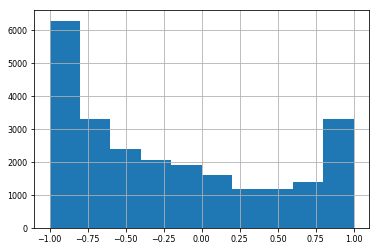

In [576]:
data.sinDOY.hist()

In [577]:
miles = list(data.groupby("mile").nunique().sort_values(by="date")[-150:].loc_id.index)

In [578]:
data = data[data.mile.isin(miles)]

In [579]:
data.shape

(8629, 20)

In [645]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.mile, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.mile, row.date), axis=1)


In [650]:
data["last"] = data[['last_pos','last_neg']].min(axis=1)

In [653]:
last_avg_source = data.groupby("mile")["last"].mean()
data["last_avg"] = data.mile.map(lambda m: last_avg_source.get(m))
data["last_neg_rel"] = data.last_neg / data.last_avg
data["last_pos_rel"] = data.last_pos / data.last_avg


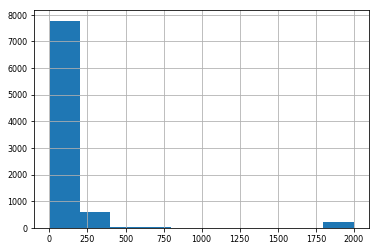

In [581]:
data.last_pos.hist()

In [582]:
data["prob_exp"] = data.apply(lambda row: data[row.mile == data.mile].status.mean(), axis=1)

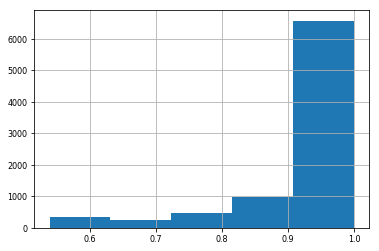

In [583]:
data.prob_exp.hist(bins=5)

In [584]:
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    print("no rain memo")
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [585]:
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(0,n)])

In [586]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)
data["rain_3"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 3), axis=1)

33.06,-116.53,1523664000 not found, calling DarkSky
33.05,-116.52,1551484800 not found, calling DarkSky
33.05,-116.52,1551398400 not found, calling DarkSky
33.05,-116.52,1551312000 not found, calling DarkSky
33.05,-116.52,1551225600 not found, calling DarkSky
33.05,-116.52,1551139200 not found, calling DarkSky
33.06,-116.53,1524787200 not found, calling DarkSky
33.06,-116.53,1524700800 not found, calling DarkSky
33.06,-116.53,1524614400 not found, calling DarkSky
33.06,-116.53,1524528000 not found, calling DarkSky
33.06,-116.53,1555200000 not found, calling DarkSky
40.05,-121.38,1411948800 not found, calling DarkSky
40.05,-121.38,1411862400 not found, calling DarkSky
40.05,-121.38,1411776000 not found, calling DarkSky
40.05,-121.38,1411689600 not found, calling DarkSky
40.05,-121.38,1411603200 not found, calling DarkSky
40.05,-121.38,1434844800 not found, calling DarkSky
40.05,-121.38,1434758400 not found, calling DarkSky
40.05,-121.38,1434672000 not found, calling DarkSky
40.05,-121.3

In [591]:
rain_5_avg_source = data.groupby("mile").rain_5.mean()
data["rain_5_avg"] = data.mile.map(lambda m: rain_5_avg_source.get(m))
data["rain_5_rel"] = data.rain_5 / data.rain_5_avg

In [592]:
rain_3_avg_source = data.groupby("mile").rain_3.mean()
data["rain_3_avg"] = data.mile.map(lambda m: rain_3_avg_source.get(m))
data["rain_3_rel"] = data.rain_3/ data.rain_3_avg

In [593]:
data[data.status==0].rain_5_rel.mean()

0.93118864744072638

In [594]:
data[data.status==1].rain_5_rel.mean()

1.0052898780951594

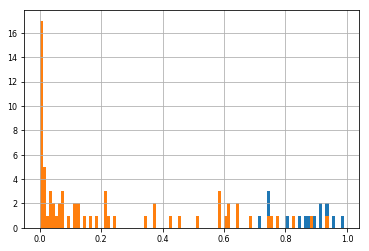

In [595]:
data[data.status==1].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,1,.01))
data[data.status==0].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,1,.01))

In [596]:
gw = pd.read_csv("ground_water/gwlevels", sep="\t")

In [597]:
def dms2lat(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[0:2], dms[2:4], dms[4:6]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return dd;

def dms2lon(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[6:9], dms[9:11], dms[11:13]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return -dd;

In [598]:
gw["lat"] = gw.site_no.map(dms2lat)
gw["lon"] = gw.site_no.map(dms2lon)

In [599]:
gw = gw[['lev_va', 'lev_dt', 'lat', 'lon', 'site_no']]
gw.columns=["meas", "date", "lat", "lon", 'site_id']

In [600]:
gw["unix_time"] = (pd.to_datetime(gw["date"], errors='coerce').astype(int)//1000000000)
gw["unix_time_reduced"] = gw["unix_time"]//10000000
data["unix_time_reduced"] = gw["unix_time"]//10000000
gw = gw.dropna()

In [601]:
kdt = KDTree(gw[['lat', 'lon', 'unix_time_reduced']])
dist, i = kdt.query(data[['lat', 'lon', 'unix_time_reduced']])

In [602]:
data['ground_water'] = gw.iloc[i.flatten()].meas.values

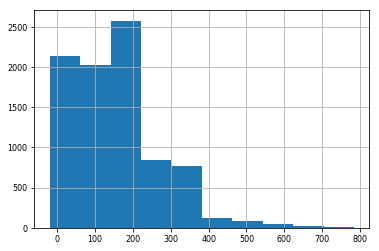

In [603]:
data.ground_water.hist()

In [604]:
data[["rain_3_rel","last_pos","last_neg","prob_exp", "month","ground_water","status"]].corr()

rain_3_rel  last_pos  last_neg      prob_exp     month  \
rain_3_rel    1.000000e+00  0.010560 -0.022266 -5.871315e-17 -0.053230   
last_pos      1.056030e-02  1.000000  0.043713 -1.252176e-01 -0.092016   
last_neg     -2.226617e-02  0.043713  1.000000  6.118092e-01  0.251718   
prob_exp     -5.871315e-17 -0.125218  0.611809  1.000000e+00  0.340031   
month        -5.322955e-02 -0.092016  0.251718  3.400314e-01  1.000000   
ground_water  2.119710e-03  0.019416 -0.099733 -1.207248e-01 -0.204658   
status        8.344292e-03 -0.204169  0.239373  4.125968e-01  0.004655   

              ground_water    status  
rain_3_rel    0.002120      0.008344  
last_pos      0.019416     -0.204169  
last_neg     -0.099733      0.239373  
prob_exp     -0.120725      0.412597  
month        -0.204658      0.004655  
ground_water  1.000000     -0.052607  
status       -0.052607      1.000000

In [605]:
data[data.status==0].sample(10).description

8566     no miracles here, still dry.                                                                                                                                                                                                                   
15690    dry as a dodo                                                                                                                                                                                                                                  
569      dry.                                                                                                                                                                                                                                           
20672    dry at the crossing. small trickle upstream.                                                                                                                                                                                                   
8107

In [677]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

from graphviz import Source

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve


from sklearn.model_selection import train_test_split

import time

from matplotlib import cm

import matplotlib.pyplot as plt

In [607]:
data[data.status == 1].shape[0]

8013

(16026,) (10709,) (2680,) (2578,)
tree
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1169
         1.0       0.88      0.89      0.89      1511

    accuracy                           0.87      2680
   macro avg       0.87      0.87      0.87      2680
weighted avg       0.87      0.87      0.87      2680

0.878492527615
tree
              precision    recall  f1-score   support

         0.0       0.44      1.00      0.61      1169
         1.0       0.00      0.00      0.00      1511

    accuracy                           0.44      2680
   macro avg       0.22      0.50      0.30      2680
weighted avg       0.19      0.44      0.26      2680

nan
dummy
              precision    recall  f1-score   support

         0.0       0.44      0.54      0.49      1169
         1.0       0.57      0.46      0.51      1511

    accuracy                           0.50      2680
   macro avg       0.50      0.50      0.50      2680
weigh

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(-0.05, 1.05)

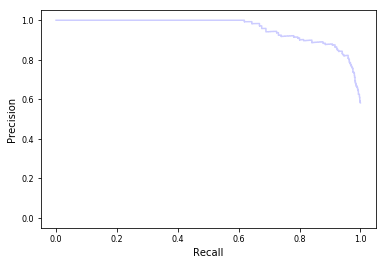

In [704]:
data_neg_over = data[data.status == 0].sample(data[data.status == 1].shape[0], replace=True)
data_over = pd.concat([data[data.status == 1], data_neg_over], axis=0)

#data_over = data
data_over = data_over.dropna(subset=['ground_water'])

inputs = data_over[["rain_3_rel","rain_5_rel","last_pos_rel","last_neg_rel","prob_exp", "sinDOY", "cosDOY","ground_water"]]
labels = data_over["status"]

X_train = inputs[data_over.mile%10. < 6]
y_train = labels[data_over.mile%10. < 6]
X_valid = inputs[(data_over.mile%10. > 6)&(data_over.mile%10. < 8)]
y_valid = labels[(data_over.mile%10. > 6)&(data_over.mile%10. < 8)]
X_test = inputs[data_over.mile%10. > 8]
y_test = labels[data_over.mile%10. > 8]
print(labels.shape, y_train.shape, y_valid.shape, y_test.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(inputs, labels, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)
#X_train, X_test, y_train, y_test = inputs[data.loc_id != "WR0004"], inputs[data.loc_id == "WR0004"],labels[data.loc_id != "WR0004"],labels[data.loc_id == "WR0004"]
#X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0, stratify=data.loc_id)

#display(X_test.groupby("loc_id").count())
#display(X_train.groupby("loc_id").count())
#dt = LogisticRegression().fit(X_train, y_train)
#dt = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#dt = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = AdaBoostClassifier().fit(X_train, y_train)
#dt = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

#print(f'Training score {lr.score(X_train, y_train)}')
#print(f'Training score {svc.score(X_train, y_train)}')
#print(f'Training score {rf.score(X_train, y_train)}')

#print('random forest')
#print(classification_report(y_test, rf.predict(X_test)))

dt_cal = CalibratedClassifierCV(dt, cv='prefit').fit(X_train, y_train)
dummy_cal = CalibratedClassifierCV(dummy, cv='prefit').fit(X_train, y_train)
dummy_majority_cal = CalibratedClassifierCV(dummy_majority, cv='prefit').fit(X_train, y_train)


print('tree')
print(classification_report(y_valid, dt.predict(X_valid)))
print(y_valid[dt.predict_proba(X_valid)[:, 1] > 0.5].mean())

print('tree')
print(classification_report(y_valid, dt.predict_proba(X_valid)[:, 1] > 0.8))
print(y_valid[dt.predict_proba(X_valid)[:, 1] > 0.8].mean())

print('dummy')
print(classification_report(y_valid, dummy.predict(X_valid)))

print('most frequent')
print(classification_report(y_valid, dummy_majority.predict(X_valid)))

precision, recall, _ = precision_recall_curve(y_valid, dt.predict_proba(X_valid)[:,1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

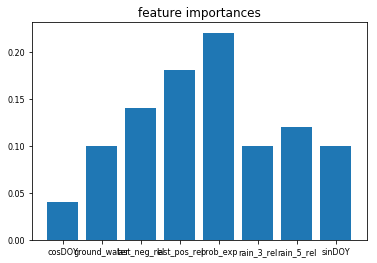

In [705]:
imp = dt.feature_importances_


plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("feature importances")
ax.bar(X_test.columns, imp)
#ax.set_xticklabels( ["ground water", "last negative observation", "last positive observation", "source probability", "rain in last 3 days", "sin(day of year)"], rotation=45 , ha="right")
plt.show()

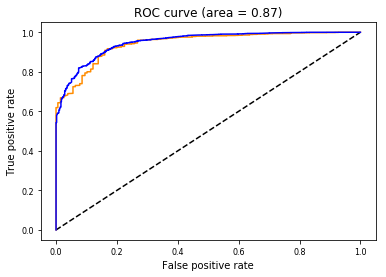

In [706]:

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

y_probs = dt.predict_proba(X_valid)[:, 1]
y_predicted = dt.predict(X_valid)
auc = roc_auc_score(y_valid, y_predicted)
false_positive, true_positive, _  = roc_curve(y_valid, y_probs)
plt.plot(false_positive, true_positive, color='darkorange', label='Decision Tree')


y_probs = dt.predict_proba(X_train)[:, 1]
y_predicted = dt.predict(X_train)
auc = roc_auc_score(y_train, y_predicted)
false_positive, true_positive, _  = roc_curve(y_train, y_probs)
plt.plot(false_positive, true_positive, color='blue', label='Decision Tree')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc)
plt.show()

In [708]:
out = []
for mile in miles:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.mile==mile].lat.values[0]
    lon = data[data.mile==mile].lon.values[0]
    rain_3_avg = data[data.mile==mile].rain_3_avg.values[0]
    rain_5_avg = data[data.mile==mile].rain_5_avg.values[0]
    last_avg = data[data.mile==mile].last_avg.values[0]
    name = data[data.mile==mile].name.mode().values[0]
    
    ["rain_3_rel","rain_5_rel","last_pos_rel","last_neg_rel","prob_exp", "sinDOY", "cosDOY","ground_water"]
    
    result = {
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': mile
    }
    
    _, i = kdt.query([[lat, lon, (now.value // 10**16) ]])
    ground_water = gw.iloc[i.flatten()].meas.values[0]
    
    for days in range(4):
        prediction = dt_cal.predict_proba([[
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 3)/rain_3_avg, 
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5)/rain_5_avg, 
                    (last_pos(mile, now) + days)/last_avg, 
                    (last_neg(mile, now) + days)/last_avg,
                    data[mile == data.mile].status.mean(),
                    np.sin(2  * np.pi * now.dayofyear/365.),
                    np.cos(2  * np.pi * now.dayofyear/365.),
                    ground_water
                ]])
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_combined.pkl', 'wb')
pickle.dump(out, f)
f.close() 

[[ 0.90414539  0.09585461]]
[[ 0.90414539  0.09585461]]
[[ 0.92922806  0.07077194]]
[[ 0.91517323  0.08482677]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.60754689  0.39245311]]
[[ 0.50671613  0.49328387]]
[[ 0.34668323  0.65331677]]
[[ 0.34668323  0.65331677]]
[[  3.33735262e-11   1.00000000e+00]]
[[  3.82955889e-11   1.00000000e+00]]
[[  9.41202671e-12   1.00000000e+00]]
[[  2.84756663e-11   1.00000000e+00]]
[[ 0.78390676  0.21609324]]
[[ 0.83637901  0.16362099]]
[[ 0.78390676  0.21609324]]
[[ 0.81381353  0.18618647]]
[[  1.00519371e-10   1.00000000e+00]]
[[  1.00519371e-10   1.00000000e+00]]
[[  4.15163459e-11   1.00000000e+00]]
[[  4.15163459e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  2.28601582e-11   1.00000000e+00]]
[[ 0.51351988  0.48648012]]
[[ 0.47689973  0.52310027]]
[[ 0.90976329  0.09023671]]
[[ 0.9097632

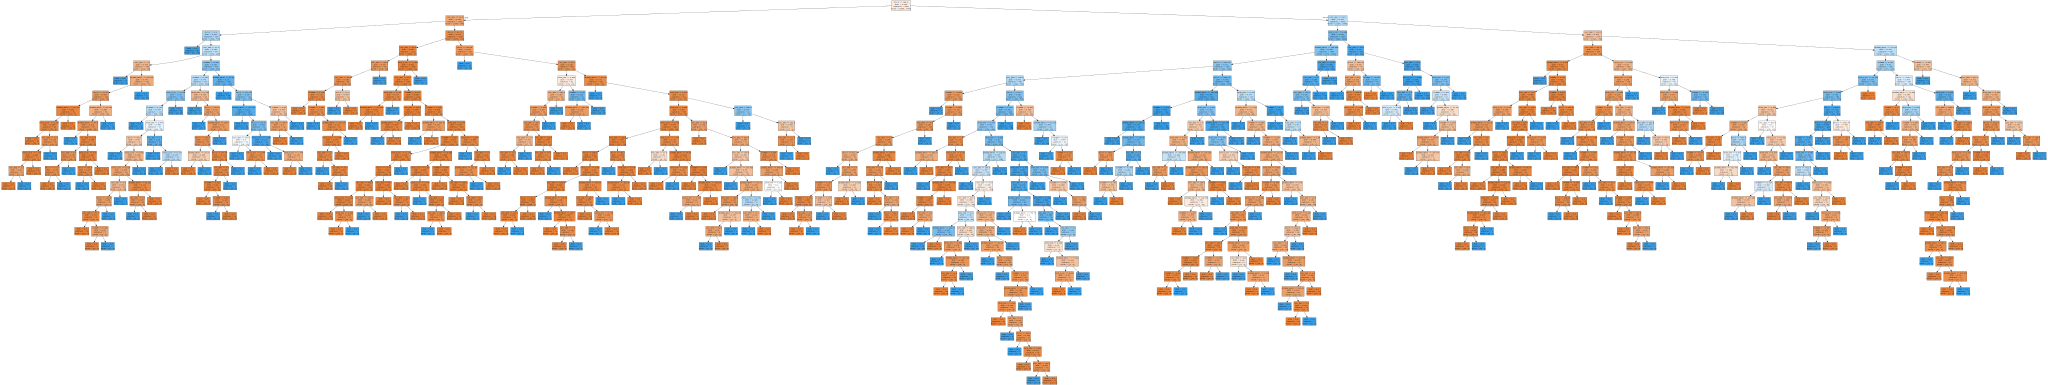

In [429]:
graph = Source( export_graphviz(dt.estimators_[0], out_file=None, feature_names=X_test.columns, filled=True))


SVG(graph.pipe(format='svg'))